In [1]:
import os
# os.chdir("/Users/davidamat/Documents/Projects/deepsetstats")
os.chdir("/Users/davidamat/Documents/Personal/deepsetstats")

from deepsetstats.utils import utils_tools
from deepsetstats.utils import constants as c
from deepsetstats.utils import videocapture as vc

import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import copy
import torch
import time

/Users/davidamat/.pyenv/versions/3.8.6/envs/deepsetstats/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
from importlib import reload
np.set_printoptions(threshold=2000)

In [3]:
utils_tools = reload(utils_tools)
c = reload(c)
vc = reload(vc)

In [4]:
# Constants



# 1. Load Videos and Dictionary of vids

In [5]:
# Dictionary of vids
extension = ".mp4"
gs = ["wb", "rg", "ao", "us"]

c.PATH_VIDS = "/Users/davidamat/Documents/BackUp/DeepSetStats"
d_path_vids = {vid: str(Path(c.PATH_VIDS) / (vid + extension)) for vid in gs }
VC = vc.VideoClass(d_path_vids["rg"])
d_vc = { grandslam: vc.VideoClass(d_path_vids[grandslam]) for grandslam in gs}

# 2. Load frames

In [6]:
l_frames = [29*25, 29*25, 29*25, 25*25]
# in Color
d_f = {
   grandslam: d_vc[grandslam].get_frame(frame_num) for grandslam, frame_num in zip(gs, l_frames)
}

# In Black and White
d_fg = {
   grandslam: d_vc[grandslam]._correct_color(d_f[grandslam], gray=True) for grandslam in gs
}

# 3. Court Detection

In [160]:
# Input frame
tourn = "ao"
frame = d_f[tourn].copy()
vt = d_vc[tourn]

## 3.1 Court Type

In [161]:
%%time
# Court type
rgb_court, court_type = VC.detect_court(frame)
print(f"Court Type: {court_type}")
print(f"Court RGB Colors: {c.D_GRAD_LINES[court_type]}")

Court Type: GREENSET_AO
Court RGB Colors: {'COURT': array([108, 156, 196]), 'LINE_CLEAN': array([200, 228, 240]), 'LINE_DIRTY': array([125, 180, 224])}
CPU times: user 3.51 ms, sys: 1.58 ms, total: 5.09 ms
Wall time: 3.34 ms


## 3.2 White Filtering

In [162]:
%%time
#mask_lines = VC.get_line_mask(frame, court_type)
#VC.show_gray(mask_lines)
# VC.show_gray(mask_lines[500:600,200:300])

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.06 µs


In [341]:
class GradientImage():
    def __init__(self, dx_pixels=6, dy_pixels=6):
        self.pixels_shift_up = dy_pixels
        self.pixels_shift_down = dy_pixels
        self.pixels_shift_left = dx_pixels
        self.pixels_shift_right = dx_pixels
    
    def get_grads(self, img):
        return self.shift_frame_up(img), self.shift_frame_down(img), self.shift_frame_left(img), self.shift_frame_right(img)
    
    def shift_frame_up(self, img):
        return np.array(
            np.vstack((
                img[self.pixels_shift_up:, :], 
                img[-self.pixels_shift_up:, :]
            )), 
            dtype=int)

    def shift_frame_down(self, img):
        return np.array(np.vstack((img[:self.pixels_shift_down, :], img[:-self.pixels_shift_down, :])), dtype=int)

    def shift_frame_left(self, img):
        return np.array(np.hstack((img[:, self.pixels_shift_left:], img[:, -self.pixels_shift_left:])), dtype=int)

    def shift_frame_right(self, img):
        return np.array(np.hstack((img[:, :self.pixels_shift_right], img[:, :-self.pixels_shift_right])), dtype=int)
    
    def get_frame_diff(self, shift_fun, img):
        frame_diff = shift_fun(img) - img
        frame_diff[frame_diff < 0] = 0
        return np.mean(frame_diff, axis=2, dtype=int)
    
    def get_frame_directions_diff(self, img):
        #shifts_dirs = [self.shift_frame_up, self.shift_frame_down, self.shift_frame_left, self.shift_frame_right]
        #shifts_dirs = [self.shift_frame_up, self.shift_frame_left]
        return (self.get_frame_diff(self.shift_frame_up, img),
            self.get_frame_diff(self.shift_frame_down, img),
            self.get_frame_diff(self.shift_frame_left, img), 
            self.get_frame_diff(self.shift_frame_right, img))
    
    @staticmethod
    def multiply_diffs(img1, img2):
        return np.sqrt(np.abs(np.multiply(img1, img2)))
    
    @staticmethod
    def apply_threshold(lines, th=50):
        mask_lines_bin = lines.copy()
        mask_idx = mask_lines_bin < th
        mask_lines_bin[mask_idx] = 1
        mask_lines_bin[~mask_idx] = 0
        return mask_lines_bin

In [342]:
%%time
grad = GradientImage()
frame_up, frame_down, frame_left, frame_right = grad.get_grads(frame)

CPU times: user 13.6 ms, sys: 2.01 ms, total: 15.6 ms
Wall time: 13 ms


In [347]:
%%time
fdup, fddown, fddleft, fddright = grad.get_frame_directions_diff(frame)
mask_lines_bin = np.maximum(grad.shift_frame_down(fdup), grad.shift_frame_left(fddright))
mask_lines_bin2 = np.maximum(grad.shift_frame_up(fddown), grad.shift_frame_right(fddleft))
mask_both = grad.multiply_diffs(mask_lines_bin, mask_lines_bin2)

CPU times: user 131 ms, sys: 12.9 ms, total: 144 ms
Wall time: 142 ms


In [ ]:
mask_final = grad.apply_threshold(mask_both, th=30)
VC.show_gray(mask_final*255)

In [372]:
gray = np.uint8(mask_final*255)
framef = frame.copy()

In [368]:
%%time
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
edges = cv2.Canny(mask_both,50,150,apertureSize = 3)

CPU times: user 10 ms, sys: 10.1 ms, total: 20.2 ms
Wall time: 9.74 ms


In [398]:
# https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html

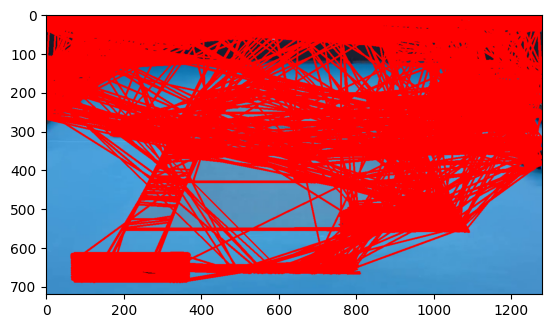

In [397]:
framef = frame.copy()
# Find the edges in the image using canny detector
edges = cv2.Canny(np.uint8(mask_both), 50, 150)
# Detect points that form a line
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 5, minLineLength=10, maxLineGap=250)
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(framef, (x1, y1), (x2, y2), (255, 0, 0), 3)
# Show result
VC.show_frame(framef)

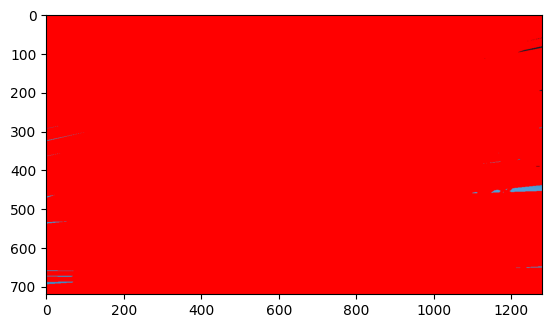

In [387]:
VC.show_frame(framef)

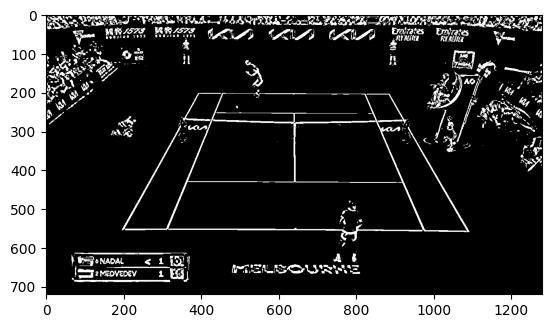

### Correct Slice

In [126]:
slif = frame[285:300, 505:506]
slim = mask_lines_bin[200:245, 400:655]

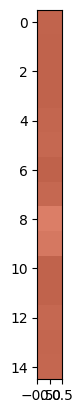

In [127]:
VC.show_frame(slif)

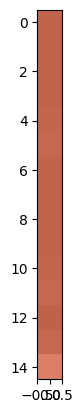

In [139]:
VC.show_frame(frame_down)

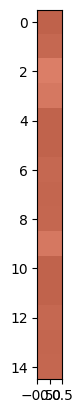

In [130]:
VC.show_frame(frame_up)

In [129]:
grad = GradientImage(slif)
frame_up, frame_down, frame_left, frame_right = grad.get_grads()

In [131]:
diff_up = slif - frame_up

In [138]:
diff_up

array([[[  2,   2,   2]],

       [[ -5,  -5,  -5]],

       [[-27, -27, -27]],

       [[-21, -21, -21]],

       [[  3,   3,   3]],

       [[  5,   5,   5]],

       [[ -6,  -6,  -6]],

       [[  2,   2,   2]],

       [[ 23,  23,  23]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]]])

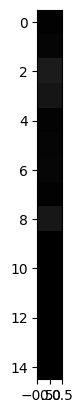

In [136]:
VC.show_frame(np.abs(diff_up))

In [307]:
sli.min(axis=1)

array([255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
         0.,   0.,   0., 255., 255., 255., 255., 255., 255.])

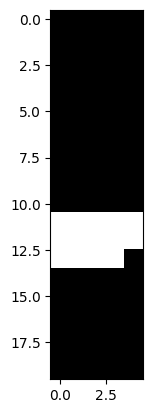

In [308]:
VC.show_gray(sli)

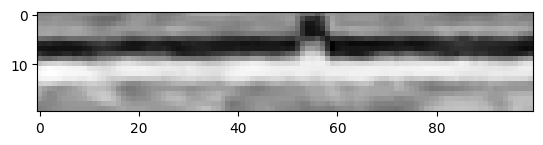

In [184]:
VC.show_gray(frame_diff_down[625:645, 600:700])

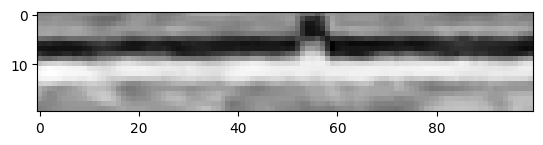

In [185]:
VC.show_gray(frame_diff_up[625:645, 600:700])

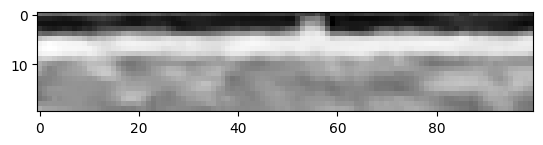

In [175]:
VC.show_gray(frame_diff_up_to_down[625:645, 600:700])

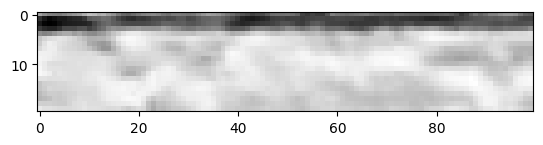

In [176]:
VC.show_gray(frame_diff_down_to_up[625:645, 600:700])

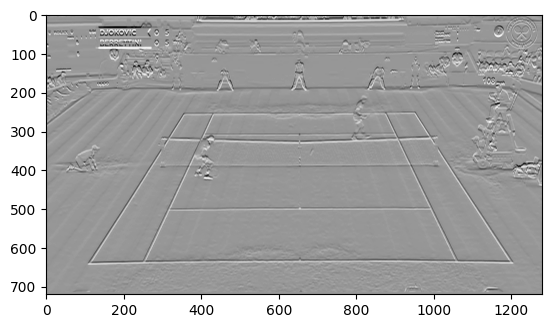

In [143]:
VC.show_gray(frame_diff_up)

In [106]:
np.max(frame_diff)

255.0

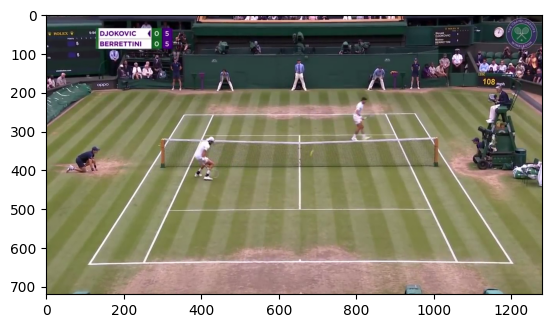

In [116]:
VC.show_frame(frame_down)